The system is governed by

\begin{equation}
\nabla\cdot \vec{u}_{tot} = 0,
\end{equation}

\begin{equation}
\partial_t \vec{u}_{tot}+\vec{u}\cdot\nabla\vec{u}_{tot} = -\nabla p_{tot} + \frac{Pr}{Pe}\nabla^2\vec{u}_{tot} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\vec{e}_z,
\end{equation}

\begin{equation}
\partial_t T +\vec{u}_{tot}\cdot\nabla T - w_{tot} = \frac{1}{Pe}\nabla^2 T,
\end{equation}

\begin{equation}
\partial_t S +\vec{u}_{tot}\cdot\nabla S - R_\rho w_{tot} = \frac{\tau}{Pe}\nabla^2 S.
\end{equation}

Decomposing nonlinear terms
$$
\vec{u}_{tot} = \bar{u}\vec{e}_x + \vec{u},
$$
$$
\vec{u}_{tot}\cdot\nabla T = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla T = \bar{u}\partial_x T + \vec{u}\cdot\nabla T,
$$
$$
\vec{u}_{tot}\cdot\nabla S = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla S = \bar{u}\partial_x S + \vec{u}\cdot\nabla S,
$$
$$
\vec{u}_{tot}\cdot\nabla \vec{u}_{tot} = (\bar{u}\vec{e}_x + \vec{u})\cdot\nabla (\bar{u}\vec{e}_x + \vec{u})\\
= \bar{u}\vec{e}_x\cdot\nabla\bar{u}\vec{e}_x + \bar{u}\vec{e}_x\cdot\nabla\vec{u} + \vec{u}\cdot\nabla\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u}\\
= 0 + \bar{u}\partial_x\vec{u} + w\partial_z\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u},
$$

The gevorning equations become:
\begin{equation}
\nabla\cdot \vec{u}_{tot} = \nabla\cdot (\bar{u}\vec{e}_x + \vec{u}) = \nabla\cdot \vec{u} = 0,
\end{equation}

\begin{equation}
\partial_t \vec{u}+\bar{u}\partial_x\vec{u} + w\partial_z\bar{u}\vec{e}_x + \vec{u}\cdot\nabla\vec{u} = -\nabla p + \frac{Pr}{Pe}\nabla^2\vec{u} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\vec{e}_z,
\end{equation}

\begin{equation}
\partial_t T +\bar{u}\partial_x T + \vec{u}\cdot\nabla T - w = \frac{1}{Pe}\nabla^2 T,
\end{equation}

\begin{equation}
\partial_t S +\bar{u}\partial_x S + \vec{u}\cdot\nabla S - R_\rho w = \frac{\tau}{Pe}\nabla^2 S.
\end{equation}

2024-08-19 23:11:32,082 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 5s, Remaining: 0s, Rate: 1.9e-01/s
Starting main loop
Completed iteration 1, time=0.200, dt=0.200


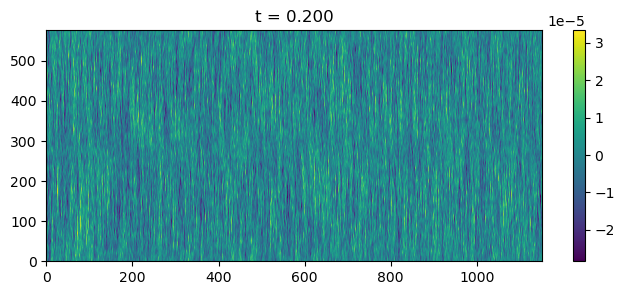

In [4]:
# This code performs two-dimensional DNS using Dedalus3 based on governing equations in Radko's paper 
# [Thermohaline layering in dynamically and diffusively stable shear flows]
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

dealias = 3/2           # scaling factor
pi = np.pi

# reproduce the results in figure 4
# Rp, Ri, Pe, tau = 2., 1., 1e4, 0.01 # figure 3
Rp, Ri, Pe, tau = 2., 10., 1e2, 0.01 # figure 4

Pr = 10.  # Prandtl number

Lx, Lz = 64., 1.
Nx, Nz = 768, 384
# Nx, Nz = 384, 192
# Nx, Nz = 768, 384

# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=np.float64)
# define the coordinate system
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)
# define fields
p = dist.Field(name='p', bases=(xbasis,zbasis)) # pressure
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis)) # velocity
sa = dist.Field(name='sa', bases=(xbasis,zbasis)) # salinity
te = dist.Field(name='te', bases=(xbasis,zbasis)) # temperature
baru = dist.Field(bases=(xbasis,zbasis))
# Substitutions
x, z = dist.local_grids(xbasis, zbasis) # get coordinate arrays in horizontal and vertical directions
ex, ez = coords.unit_vector_fields(dist) # get unit vectors in horizontal and vertical directions
# define vertical velocity component
w = u @ ez


# create constant sub-field for incompressible flow condition's equation
tau_p = dist.Field(name='tau_p') 
# because this term is only a contant added to the equation, we don't need to instantiate it for bases system

grad_te = d3.grad(te) # First-order reduction
grad_sa = d3.grad(sa) # First-order reduction
grad_u = d3.grad(u) # First-order reduction
# First-order form: "lap(f)" becomes "div(grad_f)"
lap_u = d3.div(grad_u)
lap_te = d3.div(grad_te)
lap_sa = d3.div(grad_sa)
# First-order form: "div(A)" becomes "trace(grad_A)"

dx = lambda A: d3.Differentiate(A, coords['x']) 
dz = lambda A: d3.Differentiate(A, coords['z']) 


baru['g'] = np.sin(2.*pi*z)

# baru = np.sin(2*pi*z)

# Problem
problem = d3.IVP([p, tau_p, u, te, sa], namespace=locals())

# add equations
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge
problem.add_equation("dt(u) + baru*dx(u) + w*dz(baru)*ex + grad(p) - (Pr/Pe)*lap_u - (4*pi*pi*Ri/(Rp-1))*(te-sa)*ez = - u@grad(u)")
problem.add_equation("dt(te) + baru*dx(te) - (1./Pe)*lap_te - w = - u@grad(te)")
problem.add_equation("dt(sa) + baru*dx(sa) - (tau/Pe)*lap_sa - Rp*w = - u@grad(sa)")

stop_sim_time = 1000 # Stopping criteria
# timestepper = d3.RK443 # 3rd-order 4-stage DIRK+ERK scheme [Ascher 1997 sec 2.8] https://doi-org.ezproxy.lib.uconn.edu/10.1016/S0168-9274(97)00056-1
timestepper = d3.RK222

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# define initial condition

p.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
u.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
te.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise
sa.fill_random('g', seed=42, distribution='normal', scale=0.7*1e-4) # Random noise

max_timestep = 0.2
# CFL
# CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
#              max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=1,max_dt=max_timestep,min_dt=0.0035,
            safety=1.5,
            #  threshold=0.05,
            max_change=1.5, min_change=0.5
             )
CFL.add_velocity(u)
import math
# Main loop
print('Starting main loop')
while solver.proceed:
    timestep = CFL.compute_timestep()
    solver.step(timestep)
    if solver.sim_time<420:
        if (solver.iteration-1) % 500 == 0:
            print('Completed iteration {}, time={:.3f}, dt={:.3f}'.format(solver.iteration, solver.sim_time, timestep))
            temp = np.copy(te['g'])
            plt.figure(figsize=(8,3))
            te_plot = plt.pcolormesh(temp.transpose())
            plt.colorbar(te_plot) 
            plt.title("t = {:.3f}".format(solver.sim_time))
            plt.show()
    else:
        temp = np.copy(te['g'])
        print('max. value of T = {:.5f}, dt = {:.15f})'.format(np.max(temp), timestep))
        # if (solver.iteration-1) % 10 == 0:
        if np.max(temp)>0.2:
            print('Completed iteration {}, time={:.3f}, dt={:.3f}'.format(solver.iteration, solver.sim_time, timestep))
            plt.figure(figsize=(8,3))
            te_plot = plt.pcolormesh(temp.transpose())
            plt.colorbar(te_plot) 
            plt.title("t = {:.3f}".format(solver.sim_time))
            plt.show()

        if math.isnan(np.max(temp)):
            break